# Calculating Greeks with neural network
We can calculate Greeks using our neural networks, because of the universal approximation theorem for derivatives and the fact our neural networks utilize the Softplus function which is in $C^\infty$.

This is not important with respect to calibration, but calculating Greeks is important in general and we want to make sure that we can in fact calculate them using our neural network. This module contains the outline of how we can do that.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import QuantLib as ql
import time

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import NonlinearConstraint
from scipy.misc import derivative
from sklearn.metrics import r2_score

from IPython import display

import HestonUtils
from HestonNN import Net

%matplotlib inline
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [15, 10]

if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Running on GPU')
else:
    device = torch.device('cpu')
    print('Running on CPU')

Running on GPU


The function below calculates some selected Greeks using our neural network. In particular, $\Delta, \theta, \gamma$ are calculated. In this analysis, $\mathcal{v}$ is not actually $\frac{\partial C}{\partial \sigma}$, but rather $\frac{\partial C}{\partial v_0}$.

In [2]:
# return delta, gamma, theta, vega
def nn_Greeks(net, x):
    '''
    net: desired neural network model
    x: point at which we want to evaluate Greeks
    '''
    x = torch.Tensor(x).to(device)
    x.requires_grad = True
    output = net(x)
    
    grad_params = torch.autograd.grad(output, x, create_graph=True)[0]
    delta = grad_params[0].to('cpu').detach().numpy()
    theta = -grad_params[1].to('cpu').detach().numpy()
    vega = grad_params[2].to('cpu').detach().numpy()
    gamma = torch.autograd.grad(grad_params[0], x, create_graph=True)[0][0].to('cpu').detach().numpy()
    return np.array([delta, theta, vega, gamma])

We can compare with a finite-difference approximation of the actual Greeks calculated using the QuantLib Heston pricing function.

In [3]:
# helper function
def QuantlibHestonPriceAdj(v_0, strike, current_date, maturity_date,
                spot, kappa, v_bar, sigma, rho,
                rf_rate=0, dv_rate=0,
                option_type = ql.Option.Call, day_count = ql.Actual365Fixed(), calendar = ql.UnitedStates()):
    ql.Settings.instance().evaluationDate = current_date
    
    payoff= ql.PlainVanillaPayoff(option_type, strike)
    exercise = ql.EuropeanExercise(maturity_date)
    european_option = ql.VanillaOption(payoff, exercise)
    
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot))
    rf_handle = ql.YieldTermStructureHandle(ql.FlatForward(current_date, rf_rate, day_count))
    dv_handle = ql.YieldTermStructureHandle(ql.FlatForward(current_date, dv_rate, day_count))
    heston_process = ql.HestonProcess(rf_handle, dv_handle, spot_handle,
                                      v_0, kappa, v_bar, sigma, rho)
    
    pricing_engine = ql.AnalyticHestonEngine(ql.HestonModel(heston_process))
    european_option.setPricingEngine(pricing_engine)
    heston_price = european_option.NPV()
    
    return heston_price

# calculate finite difference approximation for Greeks
def ql_Greeks(x):
    '''
    x: point at which we want to evaluate Greeks
    '''
    delta = derivative(HestonUtils.QuantlibHestonPrice, x[0], dx=1e-6, args=x[1:], n=1)
    gamma = derivative(HestonUtils.QuantlibHestonPrice, x[0], dx=1e-6, args=x[1:], n=2)
    
    v_t1 = HestonUtils.QuantlibHestonPrice(*x)
    x_t = np.array(x)
    x_t[3] = x_t[3] + 1
    v_t2 = HestonUtils.QuantlibHestonPrice(*x_t)
    theta = -(v_t2 - v_t1) / (1/365)
    
    x_v = np.array([x[4], *x[1:4], x[0], *x[5:]])
    vega = derivative(QuantlibHestonPriceAdj, x_v[0], dx=1e-6, args=x_v[1:], n=1)
    
    return np.array([delta, theta, vega, gamma])

We pull the `generateData` function from **Module 1-Data Generation** in order to generate some points at which to evaluate and compare Greeks.

In [4]:
def generateData(M=1000, data_type='NARROW', SAVE_DATA=False):
    # observed parameters: S, K, T, r, q
    Ss = np.random.uniform(low=0.5,high=1.5,size=M)
    Ks = np.array([1]*M)
    Ts = np.random.randint(low=1,high=365*2+1,size=M) / 365.
    rs = np.random.uniform(low=0,high=0.05,size=M)
    qs = np.random.uniform(low=0,high=0.05,size=M)
    
    # observe moneyness: S/K
    observed_params = np.array([Ss/Ks, Ts, rs, qs]).T
    
    # Heston parameters: v_0, kappa, v_bar, sigma, rho
    heston_params = np.zeros((M,5))
    if 'NARROW' in data_type:
        bounds = ((0, 0.5),
                  (0, 3),
                  (0, 0.5),
                  (0, 1),
                  (-0.9, 0))
    else: # WIDE
        bounds = ((0, 1),
                  (0, 10),
                  (0, 1),
                  (0, 2),
                  (-1, 0))
    bounds = np.array(bounds)
    
    for m in range(M):
        heston_params[m] = np.random.uniform(low=bounds[:,0], high=bounds[:,1])
        
        # Feller condition must be satisifed
        while 2*heston_params[m,1]*heston_params[m,2] <= heston_params[m,3]**2:
            heston_params[m] = np.random.uniform(low=bounds[:,0], high=bounds[:,1])
    
    nn_parameters = np.hstack((observed_params[:,:2], heston_params, observed_params[:,2:]))
    ql_parameters = HestonUtils.convertNNtoQLparams(nn_parameters)
    
    h_prices = np.array([HestonUtils.QuantlibHestonPrice(*ql_parameters[i]) for i in range(M)])
    
    if SAVE_DATA:
        np.save(f'data/Heston_params_{data_type}.npy', nn_parameters)
        np.save(f'data/Heston_target_{data_type}.npy', h_prices)
        
    return nn_parameters, h_prices

We can now analyze and compare some of the Greeks.

In [5]:
def analyzeGreeks(net, data_type='NARROW', STORED_DATA=True, M=10000):
    '''
    net: the neural network we want to calculate Greeks with
    data_type: either 'NARROW' or 'WIDE' depending on the kind of dataset we want to generate/use
    STORED_DATA: True if we want to use stored data, False if we want to generate our own data
    M: number of data points
    '''
    if STORED_DATA:
        data = np.load(f'data/Heston_params_{data_type}.npy')
        np.random.shuffle(data)
        nn_params = data[:M]
    else:
        nn_params = generateData(M, data_type)[0]
    ql_params = HestonUtils.convertNNtoQLparams(nn_params)
    
    time_start = time.time()
    nn_greeks = np.array([nn_Greeks(net, nn_param) for nn_param in nn_params])
    print('time taken for neural network Greeks: ', time.time()-time_start)
    
    time_start = time.time()
    ql_greeks = np.array([ql_Greeks(ql_param) for ql_param in ql_params])
    print('time taken for finite-differences of QuantLib Greeks: ', time.time()-time_start)
    
    errors = nn_greeks - ql_greeks
    
    MAE = np.mean(abs(errors), axis=0)
    MSE = np.mean(np.square(errors), axis=0)
    
    for i in range(4):
        plot_titles = ['Delta', 'Theta', 'Vega', 'Gamma']
        ql_val = ql_greeks[:,i]
        nn_val = nn_greeks[:,i]
        
        x_min, x_max = min(ql_val), max(ql_val)
        y_min, y_max = min(nn_val), max(nn_val)
        
        plt.subplot(2,2,i+1)
        plt.scatter(ql_val, nn_val, s=2)
        plt.plot(plt.xlim(),plt.xlim())
        plt.text(x=x_min,y=y_max, s=f'$R^2$ = {r2_score(ql_val,nn_val)}')
        plt.title(f'{plot_titles[i]}')
        plt.ylabel('ANN value')
        plt.xlabel('FD value')
    plt.show()
    print('MAE: ', MAE)
    print('MSE: ', MSE)
    return MAE, MSE

We now compare the Greeks calculated using $\mathcal{NN}_{narrow}$ and $\mathcal{NN}_{wide}$.

time taken for neural network Greeks:  77.32587718963623
time taken for finite-differences of QuantLib Greeks:  129.02594661712646


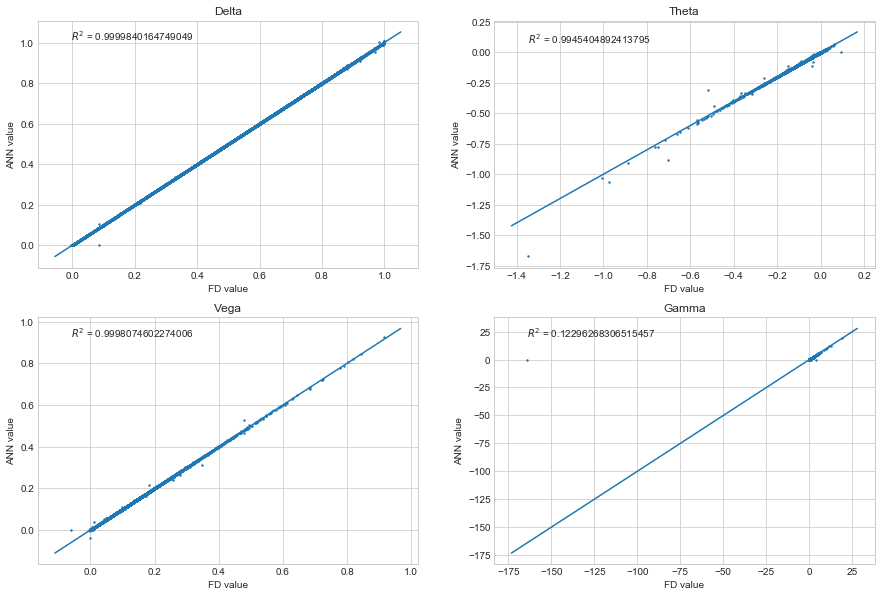

MAE:  [0.00031972 0.00037906 0.00029597 0.02671019]
MSE:  [1.13894374e-06 2.26170603e-05 1.50522586e-06 2.69294907e+00]
time taken for neural network Greeks:  75.07975244522095
time taken for finite-differences of QuantLib Greeks:  127.90594434738159


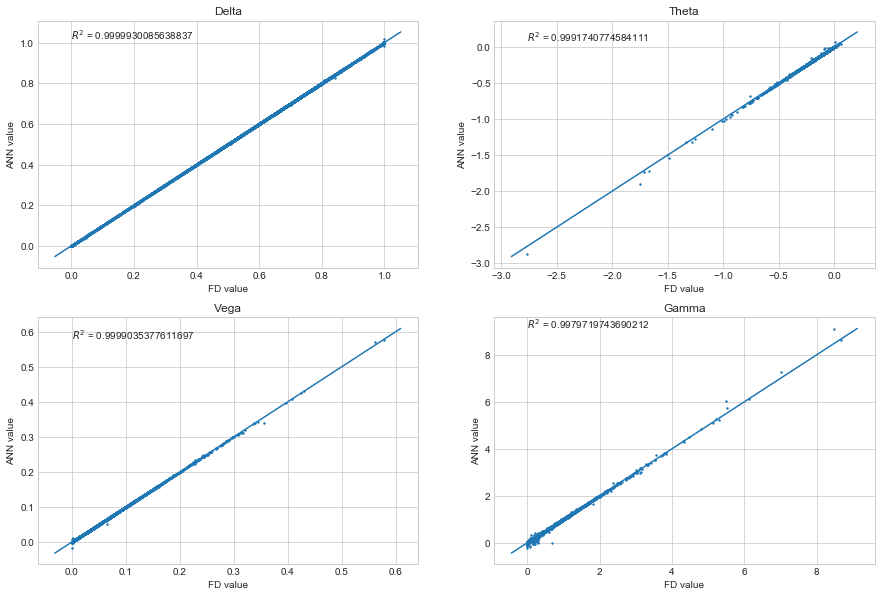

MAE:  [0.00028957 0.0005042  0.00011863 0.00847799]
MSE:  [3.52431444e-07 9.13420174e-06 1.71327049e-07 4.18538013e-04]


In [6]:
narrow_net = torch.load('models/run_133')
wide_net = torch.load('models/run_134')

np.random.seed(0)
narrow = analyzeGreeks(net=narrow_net, data_type='NARROW', M=10000)
wide = analyzeGreeks(net=wide_net, data_type='WIDE', M=10000)